In [2]:
# import libraries 
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Set of functions



def get_dynamics(graph, params, plot=False):
    """
    Function to get the dynamics of the graph
    """
    # Parameters
    alpha = params['alpha']
    beta = params['beta']
    delta = params['delta']
    do = params['do']
    I = params['I']
    rho_ss = params['rho_ss']
    O_ss = params['O_ss']
    lambda_c = params['lambda_c']
    G = graph
    n = G.number_of_nodes()
    e = G.number_of_edges()
    A = nx.adjacency_matrix(G).todense()

    
    def system(t, y, A, alpha, beta, delta, do, I):
        """
        y[k][0] is rho
        y[k][1] is O
        n repetitions for each municipality
        2 variables, rho and O
        """


        y = y.reshape(n, 2)
        
        dydt = np.zeros_like(y)

        

        def function_1(j):
            return A[i][j] * (y[j][0] - y[i][0])
        
        def function_2(j):
            return A[i][j] * ((y[i][1]/y[j][1])**I * y[j][0] - (y[j][1]/y[i][1])**I * y[i][0])
        
        def function_3(j):
            return A[i][j] * (y[j][1] - y[i][1])
        
        j = np.arange(16)
        

        for i in range(n):
            f_1_j = np.vectorize(function_1)(j)
            f_2_j = np.vectorize(function_2)(j)
            f_3_j = np.vectorize(function_3)(j)
            dydt[i, 0] = -y[i, 0] * y[i, 1] + alpha + np.sum(f_1_j) + np.sum(f_2_j)
            dydt[i, 1] = -delta * y[i, 1] + beta + y[i, 0] * y[i, 1] + do * np.sum(f_3_j)

        return dydt.flatten()
    # Initial conditions
    np.random.seed(0)
    y0 = np.random.uniform(0.01, 2, n * 2)

    # Time span
    t_span = (0, 1000)
    t_eval = np.linspace(*t_span, 100)

    # Solve the system of ODEs
    print("Starting the integration...")
    solution = sp.integrate.solve_ivp(system, t_span, y0, method='BDF', args=(A, alpha, beta, delta, do, I), t_eval=t_eval)
    print("Integration finished.")

    t = solution.t
    y = solution.y.reshape(n, 2, -1)

    # Extract the stationary state from the dynamics (the last values)
    nodes = np.arange(1, n + 1)
    last_values_rho = np.zeros(n)
    last_values_O = np.zeros(n)
    for i in range(n):
        last_values_rho[i] = y[i, 0][-1]
        last_values_O[i] = y[i, 1][-1]

    print("Linear algebra computations...")
    # Computing the spectrum of the Laplacian matrix
    L = -1 * nx.laplacian_matrix(G).todense()

    eigenvalues, eigenvectors = np.linalg.eig(L)

    # get the index of the nearest eigenvalue to lambda_c
    index_lambda_c = np.argmin(np.abs(eigenvalues - lambda_c))
    critical_eigenvector = eigenvectors[:, index_lambda_c]
    

    

    if plot:
        
        # Creating the stem plots
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))

        axes[0].stem(nodes, last_values_rho, linefmt='gray', markerfmt='ko', basefmt=' ', bottom=rho_ss)
        axes[0].axhline(rho_ss, color='red', linestyle='--')


        # Labeling the axes
        axes[0].set_xlabel('Nodes')
        axes[0].set_ylabel('rho')

        axes[1].stem(nodes, last_values_O, linefmt='gray', markerfmt='ko', basefmt=' ', bottom=O_ss)
        axes[1].axhline(O_ss, color='red', linestyle='--')

        # Labeling the axes
        axes[1].set_xlabel('Nodes')
        axes[1].set_ylabel('O')

        axes[2].stem(nodes, critical_eigenvector, linefmt='gray', markerfmt='ko', basefmt=' ')
        axes[2].axhline(0, color='red', linestyle='--')

        # Labeling the axes
        axes[2].set_xlabel('Nodes')
        axes[2].set_ylabel('eigenvector')

        # Display the plot
        plt.show()

    # Variance 
    variance_rho = np.var(last_values_rho)
    variance_O = np.var(last_values_O)
    variance_eigenvector = np.var(critical_eigenvector)

    # Inverse Participation Ratio (IPR)
    ipr_rho = np.sum(last_values_rho**4) / (np.sum(last_values_rho**2)**2)
    ipr_O = np.sum(last_values_O**4) / (np.sum(last_values_O**2)**2)
    ipr_eigenvector = np.sum(critical_eigenvector**4) / (np.sum(critical_eigenvector**2)**2)

    # Network average degree
    k_avg = 2 * e / n

    print("Computations finished.")
    
    



    # Return the results
    return {
        'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
        'last_values_rho': last_values_rho.tolist(),
        'last_values_O': last_values_O.tolist(),
        'critical_eigenvector': critical_eigenvector.tolist(),
        'variance_rho': float(variance_rho),
        'variance_O': float(variance_O),
        'variance_eigenvector': float(variance_eigenvector),
        'ipr_rho': float(ipr_rho),
        'ipr_O': float(ipr_O),
        'ipr_eigenvector': float(ipr_eigenvector),
        'k_avg': float(k_avg),
    }
        


        


    

In [17]:
# Create an empty graph
G = nx.Graph()

# Add nodes
nodes = range(1, 17)
G.add_nodes_from(nodes)

# Add edges based on the visual structure
edges = [
    (1, 2), (1, 3), (1, 4), (2, 4), (2,5), (3, 4), (3, 6), (3, 7), (3, 8), (4, 5), (4, 8), (4, 9),
    (5, 9), (6, 7), (7, 8), (7, 11), (7, 10), (7, 13), (8, 9), (8, 11), (8, 12), (9, 12),
    (10, 13), (11, 12), (11, 13), (11, 14), (12, 14), (12, 15), (13, 14), (13, 16) ,(14, 15),
    (14, 16), (15, 16)
]
G.add_edges_from(edges)

# Set parameters
alpha = 0.0050415
beta = 0.000013047
delta = 0.0079639
do = 0.0017783
numerator = 2 * delta**2 * beta + do * (alpha + beta)**2 + 2 * (alpha + beta) * delta * np.sqrt(2 * do * (alpha + beta))
denominator = 2 * alpha * delta**2
Ic = numerator / denominator
I = Ic + 0.1

# Critical eigenvalue, must be 1.19198455
lambda_c = (do * (alpha + beta)**2 + 2 * beta * delta**2 - 2 * I * alpha * delta**2) / (4 * do * delta * (alpha + beta))

# Compute the homogeneous steady states
rho_ss = alpha * delta / (alpha + beta)
O_ss = (alpha + beta) / delta
params = {
    'alpha': alpha,
    'beta': beta,
    'delta': delta,
    'do': do,
    'I': I,
    'rho_ss': rho_ss,
    'O_ss': O_ss,
    'lambda_c': lambda_c
}

In [18]:
params

{'alpha': 0.0050415,
 'beta': 1.3047e-05,
 'delta': 0.0079639,
 'do': 0.0017783,
 'I': np.float64(0.7074034423516578),
 'rho_ss': 0.007943343261028139,
 'O_ss': 0.6346823792363039,
 'lambda_c': np.float64(-1.415470896407335)}

Starting the integration...
Integration finished.
Linear algebra computations...


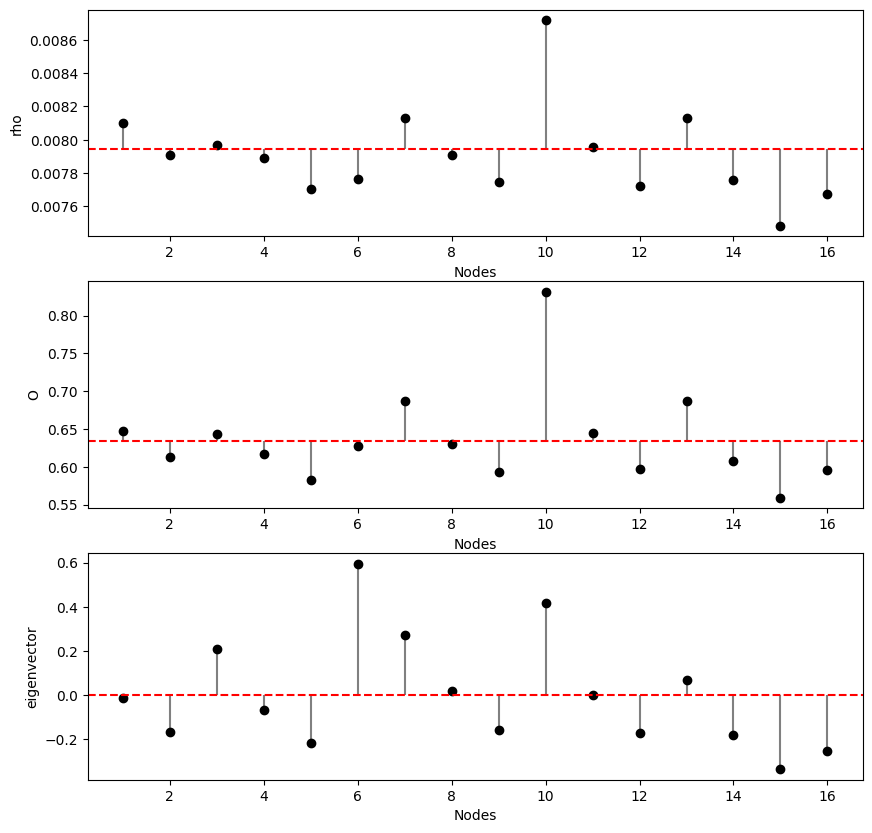

Computations finished.


{'critical_eigenvalue': -1.192131278815221,
 'last_values_rho': [0.008097470818598101,
  0.00790803410965585,
  0.00797027815313591,
  0.007892437595203038,
  0.007706424019903598,
  0.007762840165636633,
  0.008127962584828242,
  0.007908510455618198,
  0.007748705064112468,
  0.008718381070980169,
  0.007956543803317014,
  0.007722635521025119,
  0.008133056763319742,
  0.0077594777973907635,
  0.007483043598120699,
  0.007677345910411081],
 'last_values_O': [0.6475096928565413,
  0.6125674137366104,
  0.6437822768358845,
  0.6167117196618108,
  0.582188605528202,
  0.6270136575253504,
  0.686898581357218,
  0.6300528203476189,
  0.5938616187116731,
  0.8316219981777405,
  0.6451194086653227,
  0.5968154702282665,
  0.6868882426893623,
  0.6083122570421947,
  0.55929643322287,
  0.5955018921105724],
 'critical_eigenvector': [-0.014136992519184132,
  -0.16672971189158284,
  0.21017903177304467,
  -0.06900714646851831,
  -0.2182812920332394,
  0.5960491453376587,
  0.27135042903417467,

In [19]:
get_dynamics(G, params, plot=True)

In [6]:
# Create the experiments

def experiments(n_nodes, n_neighbors, n_experiments, sample_size, params):
    print("Starting the experiments...")
    transitivity = []
    average_path_length = []
    p_values = np.logspace(-4, 0, n_experiments)
    small_world_graphs = []

    # List that will contain the dynamics of the graphs
    dynamics_data = {}
    # Max clustering coefficient
    max_clustering = 3/4 * (n_neighbors - 2) / (n_neighbors - 1)
    # Max length
    max_length = n_nodes / (2 * n_neighbors)

    # Compute the transitivity and average length path for each graph
    for i, p in enumerate(p_values):
        print(f"Computing graph {i + 1}/{n_experiments}...")
        small_world_graphs = []
        transitivities = []
        avg_lenghts = []
        dynamics = []
        print("Computing samples...")
        for seed in range(sample_size):
            small_world_graphs.append(nx.newman_watts_strogatz_graph(n=n_nodes, k=n_neighbors, p=p, seed=seed))
        print("Computing dynamics...")
        transitivities = list(map(lambda x: nx.transitivity(x) / max_clustering, small_world_graphs))
        avg_lenghts = list(map(lambda x: nx.average_shortest_path_length(x) / max_length, small_world_graphs))  
        dynamics = list(map(lambda x: get_dynamics(x, params), small_world_graphs))
        
        
        transitivity.append(np.mean(transitivities))
        average_path_length.append(np.mean(avg_lenghts))
        dynamics_data[p] = dynamics

    # Save the data for each p
    data_ipr_rho = sum([list(map(lambda x: x['ipr_rho'], dynamics_data[p])) for p in p_values], [])
    data_ipr_O = sum([list(map(lambda x: x['ipr_O'], dynamics_data[p])) for p in p_values], [])
    data_ipr_eigenvector = sum([list(map(lambda x: x['ipr_eigenvector'], dynamics_data[p])) for p in p_values], [])
    data_variance_rho = sum([list(map(lambda x: x['variance_rho'], dynamics_data[p])) for p in p_values], [])
    data_variance_O = sum([list(map(lambda x: x['variance_O'], dynamics_data[p])) for p in p_values], [])
    data_variance_eigenvector = sum([list(map(lambda x: x['variance_eigenvector'], dynamics_data[p])) for p in p_values], [])
    data_k_avg = sum([list(map(lambda x: x['k_avg'], dynamics_data[p])) for p in p_values], [])
    
    data_p = sum([[p] * sample_size for p in p_values], [])

    # Plot the results
    print("Plotting the results...")
    fig, axes = plt.subplots(5, 1, figsize=(10, 12))

    # Plot transitivity and average path length
    axes[0].plot(p_values, transitivity, label='Transitivity')
    axes[0].plot(p_values, average_path_length, label='Average Path Length')
    axes[0].set_xlabel('p')
    axes[0].set_xscale('log')
    axes[0].legend()
    axes[0].set_title('Transitivity and Average Path Length')
    axes[0].grid(True)

    # Plot dynamics: IPR
    axes[1].scatter(data_p, data_ipr_rho, label='IPR rho', alpha=0.7)
    axes[1].scatter(data_p, data_ipr_O, label='IPR O', alpha=0.7)
    axes[1].set_xlabel('p')
    axes[1].set_xscale('log')
    axes[1].legend()
    axes[1].set_title('Dynamics: IPR')
    axes[1].grid(True)

    # Plot variance
    axes[2].scatter(data_p, data_variance_rho, label='Variance rho', alpha=0.7)
    axes[2].scatter(data_p, data_variance_O, label='Variance O', alpha=0.7)
    axes[2].set_xlabel('p')
    axes[2].set_xscale('log')
    axes[2].legend()
    axes[2].set_title('Variance')
    axes[2].grid(True)

    # Plot IPR eigenvector
    axes[3].scatter(data_p, data_ipr_eigenvector, label='IPR eigenvector', alpha=0.7)
    axes[3].set_xlabel('p')
    axes[3].set_xscale('log')
    axes[3].legend()
    axes[3].set_title('IPR Eigenvector')
    axes[3].grid(True)

    # Plot variance eigenvector
    axes[4].scatter(data_p, data_variance_eigenvector, label='Variance eigenvector', alpha=0.7)
    axes[4].set_xlabel('p')
    axes[4].set_xscale('log')
    axes[4].legend()
    axes[4].set_title('Variance Eigenvector')
    axes[4].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "dynamics_data": dynamics_data,
        "data_ipr_rho": data_ipr_rho,
        "data_ipr_O": data_ipr_O,
        "data_ipr_eigenvector": data_ipr_eigenvector,
        "data_variance_rho": data_variance_rho,
        "data_variance_O": data_variance_O,
        "data_variance_eigenvector": data_variance_eigenvector,
        "data_k_avg": data_k_avg
    }


Starting the experiments...
Computing graph 1/10...
Computing samples...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graph 2/10...
Computing samples...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graph 3/10...
Computing samples...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Computing graph 4/10...
Computing samples...
Computing dynamics...
Starting the integration...
Integration finished.
Linear algebra computations...

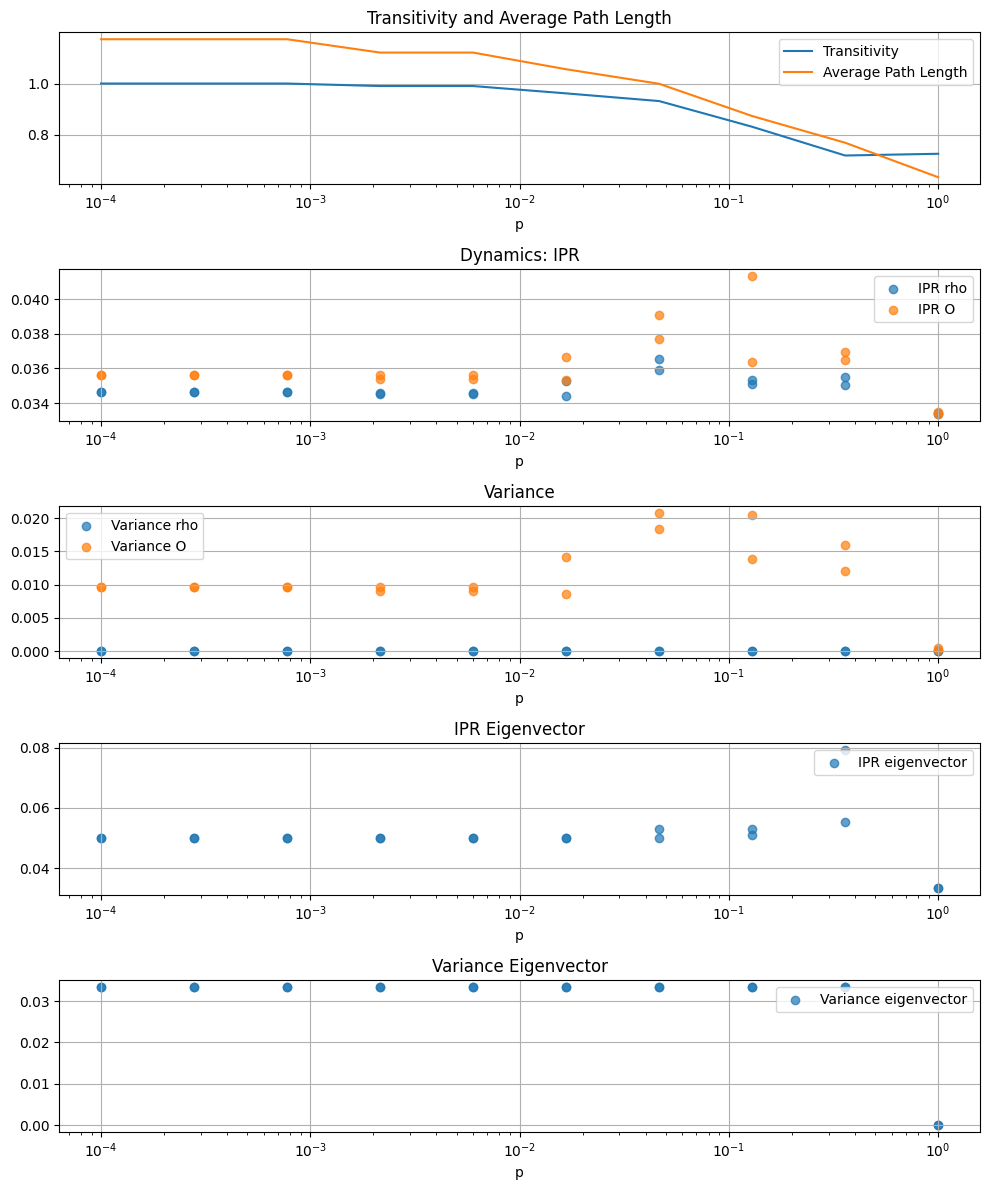

{'dynamics_data': {np.float64(0.0001): [{'critical_eigenvalue': -2.2166138832471804, 'last_values_rho': [0.008069369484021295, 0.007757991823145214, 0.007793425361537228, 0.007848646375082624, 0.00780989513852471, 0.007910842841756038, 0.008021379685619084, 0.008095398401131403, 0.008191136477534697, 0.008217009270683206, 0.00818974370770322, 0.008087548342653987, 0.007922520014682726, 0.007845419749730924, 0.007639427228197823, 0.007451296886199155, 0.006811399902373398, 0.0056427017689586936, 0.007355472924916334, 0.007932542688189478, 0.007939240168919247, 0.007939501526918984, 0.007934794593733245, 0.007943088492244146, 0.007940227913686957, 0.007937463136890617, 0.00793674089393442, 0.0041482318525373554, 0.005807604486486839, 0.0069190259692731085], 'last_values_O': [0.6547344961459031, 0.6224460694396733, 0.6265632638216883, 0.6325340974268451, 0.6288520448208552, 0.6395144381491416, 0.6507461465356832, 0.6577757198745879, 0.6663127794936624, 0.6667269643972175, 0.66119525785925

In [7]:
experiment = experiments(30, 6, 10, 2, params)
print(experiment)

In [8]:
from multiprocessing import Pool

def process_graph(args):
    """Helper function to process a single graph with given parameters"""
    p, seed, n_nodes, n_neighbors, params = args
    graph = nx.newman_watts_strogatz_graph(n=n_nodes, k=n_neighbors, p=p, seed=seed)
    max_clustering = 3/4 * (n_neighbors - 2) / (n_neighbors - 1)
    max_length = n_nodes / (2 * n_neighbors)
    
    transitivity = nx.transitivity(graph) / max_clustering
    avg_length = nx.average_shortest_path_length(graph) / max_length
    
    dynamics = get_dynamics(graph, params)

    # Compute the measures for the random erdos renyi graph
    transitivity_random = (dynamics["k_avg"] / n_nodes) / max_clustering
    avg_length_random = (np.log(n_nodes) / np.log(dynamics["k_avg"])) / max_length
    sigma = (transitivity / transitivity_random) / (avg_length / avg_length_random)

    return {
        'transitivity': transitivity,
        'avg_length': avg_length,
        'dynamics': dynamics,
        'sigma': sigma
    }

def experiments(n_nodes, n_neighbors, n_experiments, sample_size, params):
    print("Starting the experiments...")
    transitivity = []
    average_path_length = []
    sigma_data = []
    p_values = np.logspace(-4, 0, n_experiments)
    dynamics_data = {}

    # Create process pool
    with Pool() as pool:
        for i, p in enumerate(p_values):
            print(f"Computing graph {i + 1}/{n_experiments}...")
            
            # Prepare arguments for parallel processing
            args = [(p, seed, n_nodes, n_neighbors, params) for seed in range(sample_size)]
            
            # Process graphs in parallel
            results = pool.map(process_graph, args)
            
            # Extract results
            transitivities = [r['transitivity'] for r in results]
            avg_lengths = [r['avg_length'] for r in results]
            dynamics = [r['dynamics'] for r in results]
            sigmas = [r['sigma'] for r in results]
            
            transitivity.append(np.mean(transitivities))
            average_path_length.append(np.mean(avg_lengths))
            dynamics_data[p] = dynamics
            # If all small_worlds are True, set the condition to True
            sigma_data.append(np.mean(sigmas))


    # Rest of the code remains the same
    data_ipr_rho = sum([list(map(lambda x: x['ipr_rho'], dynamics_data[p])) for p in p_values], [])
    data_ipr_O = sum([list(map(lambda x: x['ipr_O'], dynamics_data[p])) for p in p_values], [])
    data_ipr_eigenvector = sum([list(map(lambda x: x['ipr_eigenvector'], dynamics_data[p])) for p in p_values], [])
    data_variance_rho = sum([list(map(lambda x: x['variance_rho'], dynamics_data[p])) for p in p_values], [])
    data_variance_O = sum([list(map(lambda x: x['variance_O'], dynamics_data[p])) for p in p_values], [])
    data_variance_eigenvector = sum([list(map(lambda x: x['variance_eigenvector'], dynamics_data[p])) for p in p_values], [])
    data_k_avg = sum([list(map(lambda x: x['k_avg'], dynamics_data[p])) for p in p_values], [])
    
    data_p = sum([[p] * sample_size for p in p_values], [])

    # Plot the results
    print("Plotting the results...")
    fig, axes = plt.subplots(5, 1, figsize=(10, 12))

    # Plot transitivity and average path length
    axes[0].plot(p_values, transitivity, label='Transitivity')
    axes[0].plot(p_values, average_path_length, label='Average Path Length')
    # Plot vertical line for small world condition when True
    axes[0].plot(p_values, sigma_data, label='Small-world-ness')
    axes[0].set_xlabel('p')
    axes[0].set_xscale('log')
    axes[0].legend()
    axes[0].set_title('Transitivity and Average Path Length')
    axes[0].grid(True)

    # Plot dynamics: IPR
    axes[1].scatter(data_p, data_ipr_rho, label='IPR rho', alpha=0.7)
    axes[1].scatter(data_p, data_ipr_O, label='IPR O', alpha=0.7)
    axes[1].set_xlabel('p')
    axes[1].set_xscale('log')
    axes[1].legend()
    axes[1].set_title('Dynamics: IPR')
    axes[1].grid(True)

    # Plot variance
    axes[2].scatter(data_p, data_variance_rho, label='Variance rho', alpha=0.7)
    axes[2].scatter(data_p, data_variance_O, label='Variance O', alpha=0.7)
    axes[2].set_xlabel('p')
    axes[2].set_xscale('log')
    axes[2].legend()
    axes[2].set_title('Variance')
    axes[2].grid(True)

    # Plot IPR eigenvector
    axes[3].scatter(data_p, data_ipr_eigenvector, label='IPR eigenvector', alpha=0.7)
    axes[3].set_xlabel('p')
    axes[3].set_xscale('log')
    axes[3].legend()
    axes[3].set_title('IPR Eigenvector')
    axes[3].grid(True)

    # Plot variance eigenvector
    axes[4].scatter(data_p, data_variance_eigenvector, label='Variance eigenvector', alpha=0.7)
    axes[4].set_xlabel('p')
    axes[4].set_xscale('log')
    axes[4].legend()
    axes[4].set_title('Variance Eigenvector')
    axes[4].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "dynamics_data": dynamics_data,
        "data_ipr_rho": data_ipr_rho,
        "data_ipr_O": data_ipr_O,
        "data_ipr_eigenvector": data_ipr_eigenvector,
        "data_variance_rho": data_variance_rho,
        "data_variance_O": data_variance_O,
        "data_variance_eigenvector": data_variance_eigenvector,
        "data_k_avg": data_k_avg
    }

Starting the experiments...


Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 1/20...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 2/20...
Integration finished.
Linear algebra computations...Integration finished.

Linear algebra computations...
Computations finished.
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computin

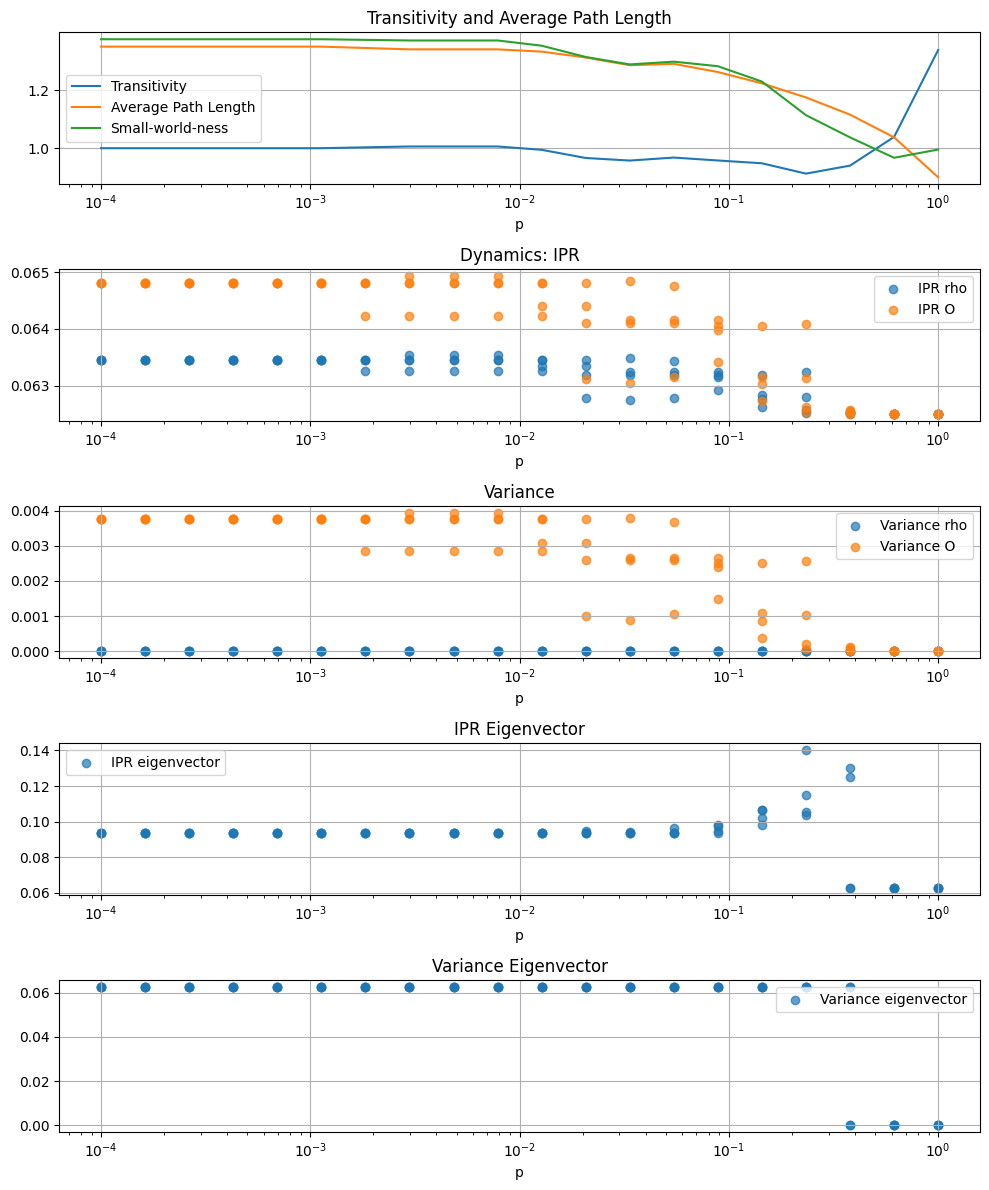

{'dynamics_data': {np.float64(0.0001): [{'critical_eigenvalue': -1.9726605078741528, 'last_values_rho': [0.00748826580414254, 0.007305933891784921, 0.0072225698994504576, 0.007241094347653068, 0.007327361742445438, 0.007518158963384243, 0.007770644910399933, 0.00802305618830496, 0.008292355451654732, 0.008490684517514415, 0.008587407463110345, 0.008582626479018337, 0.008453080214384515, 0.008248653947979521, 0.007980216788561445, 0.007712863129569546], 'last_values_O': [0.584399703173267, 0.5625878083473677, 0.552489887893654, 0.5544520947432291, 0.5652747860478331, 0.5882900387935156, 0.6191556395355773, 0.6512068532442259, 0.6850456657052412, 0.7105621348578447, 0.7233052354405444, 0.7225332929569234, 0.7059036634903085, 0.6794560328906459, 0.6456423290105296, 0.6122699042407712], 'critical_eigenvector': [0.13954233721338527, 0.2532352659053861, 0.328375420946694, 0.3535233948794713, 0.32485063663940356, 0.24672231374934142, 0.13103275513428483, -0.004605352635082957, -0.139542337213

In [9]:
experiment = experiments(16, 6, 20, 4, params)
print(experiment)

Starting the experiments...
Starting the integration...Starting the integration...Starting the integration...


Computing graph 1/20...
Starting the integration...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...


Starting the integration...
Computing graph 2/20...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting th

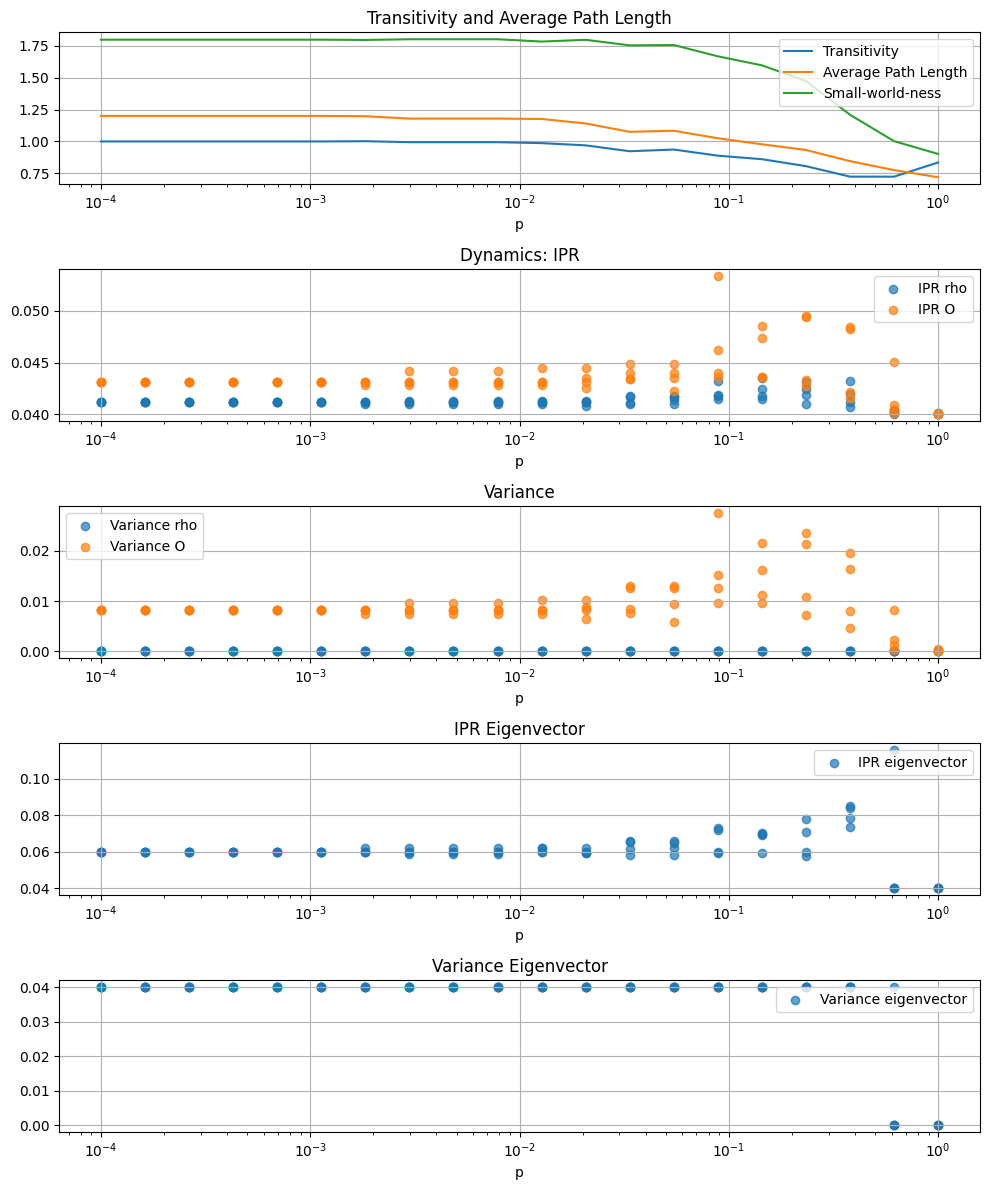

{'dynamics_data': {np.float64(0.0001): [{'critical_eigenvalue': -0.8522830628121896, 'last_values_rho': [0.008070525412008582, 0.007757290901448049, 0.0077927767665100225, 0.00784832777799517, 0.007808755829782324, 0.007910003230082136, 0.008021061989055108, 0.008094773894832416, 0.008191267908076023, 0.00821743344212383, 0.0081901433128054, 0.008087839088432476, 0.007922441338928174, 0.007845349166593732, 0.0076382821267524815, 0.007450262297575635, 0.006809536514378468, 0.005640741001042848, 0.007354708385253829, 0.007931946718421101, 0.007939132245646572, 0.007939402844265043, 0.00880662678280712, 0.00564405106878854, 0.0070214828558969825], 'last_values_O': [0.6549077299263255, 0.6224187446266586, 0.6265396411659875, 0.632541807050555, 0.6287774035544832, 0.6394697605657264, 0.6507532178613059, 0.6577592067336656, 0.6663705321250928, 0.6668143278507875, 0.6612798328440525, 0.6475689513951158, 0.6269191473494634, 0.6170300386610336, 0.5938091809681865, 0.5712616963960251, 0.50172090

In [10]:
experiment_2 = experiments(25, 6, 20, 4, params)
print(experiment_2)

Starting the experiments...
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 1/20...
Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Integration finished.Linear algebra computations...

Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),


Computations finished.

/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Starting the integration...Starting the integration...Starting the integration...


Starting the integration...
Computing graph 2/20...
Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 3/20...
Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),


Integration finished.

/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),



Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 4/20...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 5/20...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.Integration finished.

Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computin

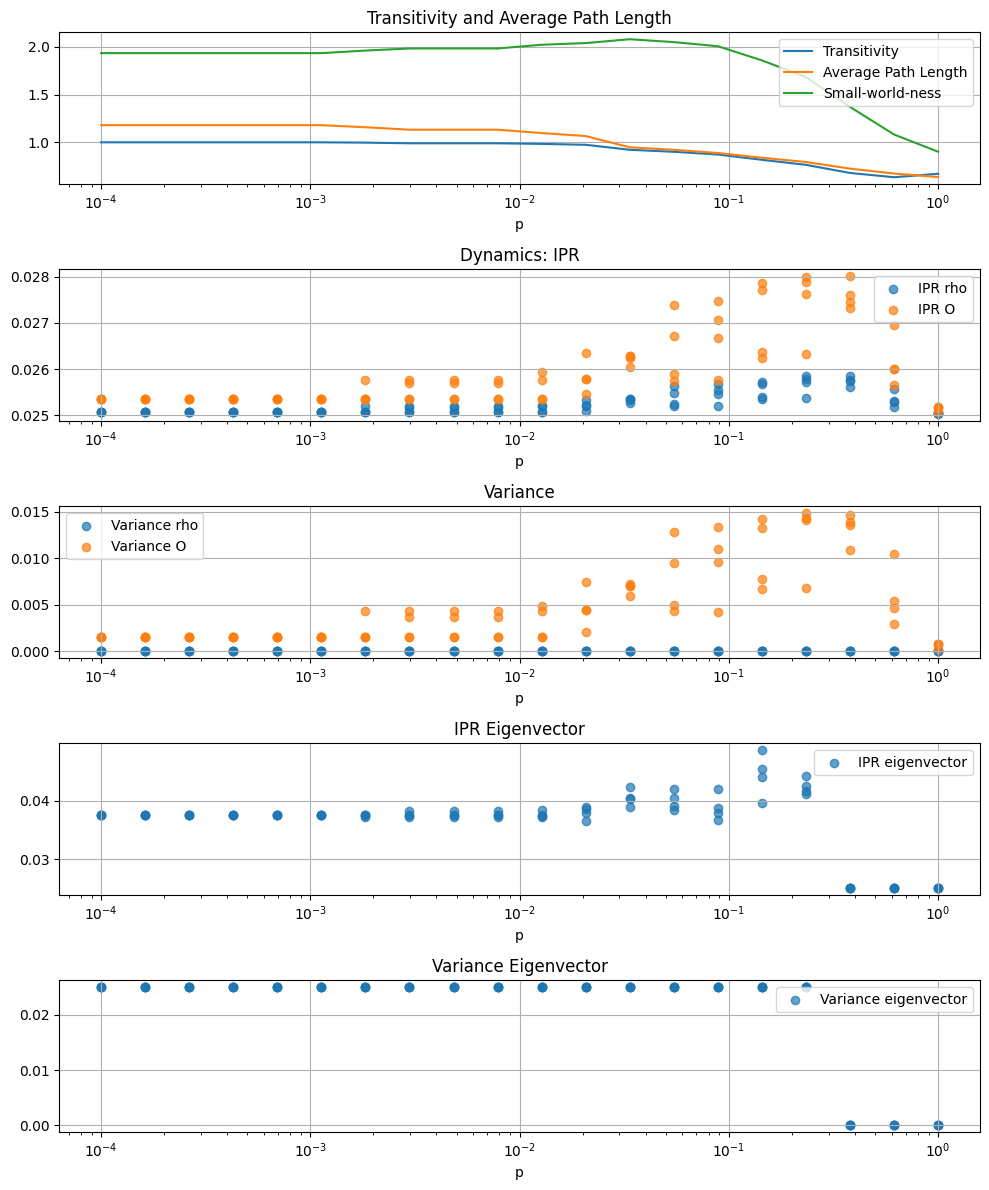

{'dynamics_data': {np.float64(0.0001): [{'critical_eigenvalue': -0.7224632490927867, 'last_values_rho': [0.007912260481837212, 0.007912556224662274, 0.007919763112026083, 0.0079236028963426, 0.007926612533197468, 0.007931618624261482, 0.007937258432950327, 0.00794095194960092, 0.00794433420245605, 0.007947432673872719, 0.007948063410638053, 0.007947621388205088, 0.007948287100595438, 0.007948946207023317, 0.007943618468987255, 0.007941676005725774, 0.007891554187673342, 0.0077507361626278845, 0.007537352956376099, 0.0082360821512421, 0.007939112670884804, 0.00793938527381626, 0.007934350040594316, 0.007943082076388738, 0.007940139739903665, 0.007937240400672656, 0.007936468725356163, 0.00794282027513098, 0.007938124994732051, 0.007939847878980187, 0.007943686231241823, 0.007939090446711749, 0.00794114040427289, 0.007937988743180765, 0.007937847657554765, 0.0079333839936457, 0.008316328724556168, 0.006758811847933066, 0.0075194483465685965, 0.007809942505302669], 'last_values_O': [0.630

In [20]:
experiment_3 = experiments(40, 8, 20, 4, params)
print(experiment_3)

Starting the experiments...
Starting the integration...Starting the integration...
Starting the integration...
Starting the integration...

Computing graph 1/20...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 2/20...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting th

/tmp/ipykernel_383813/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_383813/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 13/20...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Starting the integration...Starting the integration...Starting the integration...

Starting the integration...

Computing graph 14/20...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.
Linear algebra compu

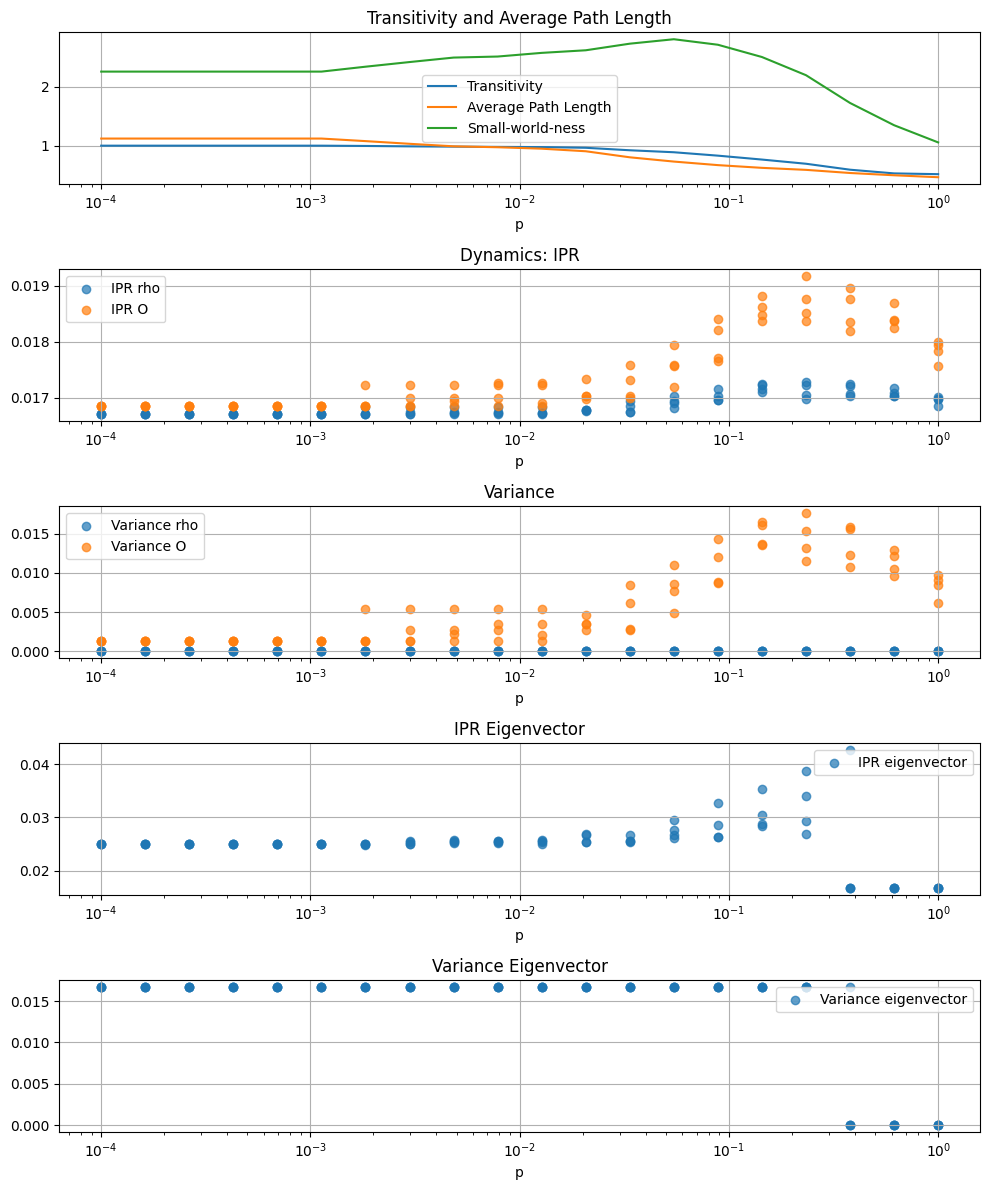

{'dynamics_data': {np.float64(0.0001): [{'critical_eigenvalue': -1.2603186817795815, 'last_values_rho': [0.007913275673366504, 0.0079137213698872, 0.00792086863887327, 0.007924633443712513, 0.007927862752940728, 0.007932827348254883, 0.007938302369854327, 0.00794229008751715, 0.007945491981655678, 0.007948526881856427, 0.007949197868726953, 0.007948800901346063, 0.007949489665583776, 0.007950013804775908, 0.007944957387392268, 0.007942828303165117, 0.007892622434129571, 0.00775142662833852, 0.007537730023815444, 0.008237539975774312, 0.00793977740265393, 0.00794000730297712, 0.007935757027423385, 0.007943123227857556, 0.007940643476611388, 0.007938197841319366, 0.00793754648010574, 0.007942902660335854, 0.007938944271039451, 0.007940397393264324, 0.007943632170682089, 0.007939758658543484, 0.0079414870322974, 0.00793882931621006, 0.007938710277047591, 0.007934940509819962, 0.007933925871180983, 0.007939842590447492, 0.00794265257199038, 0.007942564812461167, 0.007940253310958214, 0.007

In [21]:
experiment_4 = experiments(60, 8, 20, 4, params)
print(experiment_4)

Starting the experiments...
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 1/20...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Computations finished.


/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Computations finished.


/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Linear algebra computations...
Computations finished.Computations finished.



/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 2/20...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Computations finished.
Integration finished.

/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),


/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Linear algebra computations...
Computations finished.


/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Computations finished.


/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Computations finished.


/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Starting the integration...Starting the integration...

Starting the integration...Starting the integration...

Computing graph 3/20...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...Integration finished.

Linear algebra computations...
Computations finished.


/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Integration finished.
Computations finished.Linear algebra computations...



/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Computations finished.


/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Computations finished.


/tmp/ipykernel_374117/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),
/tmp/ipykernel_374117/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),


Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 4/20...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Computations finished.
Computations finished.
Computations finished.
Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 5/20...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Computations finished.
Computations finished.
Computations finished.
Computations finished.
Starting the integration...Starting the integration...Starting the integration...
Starting the integration...


Computin

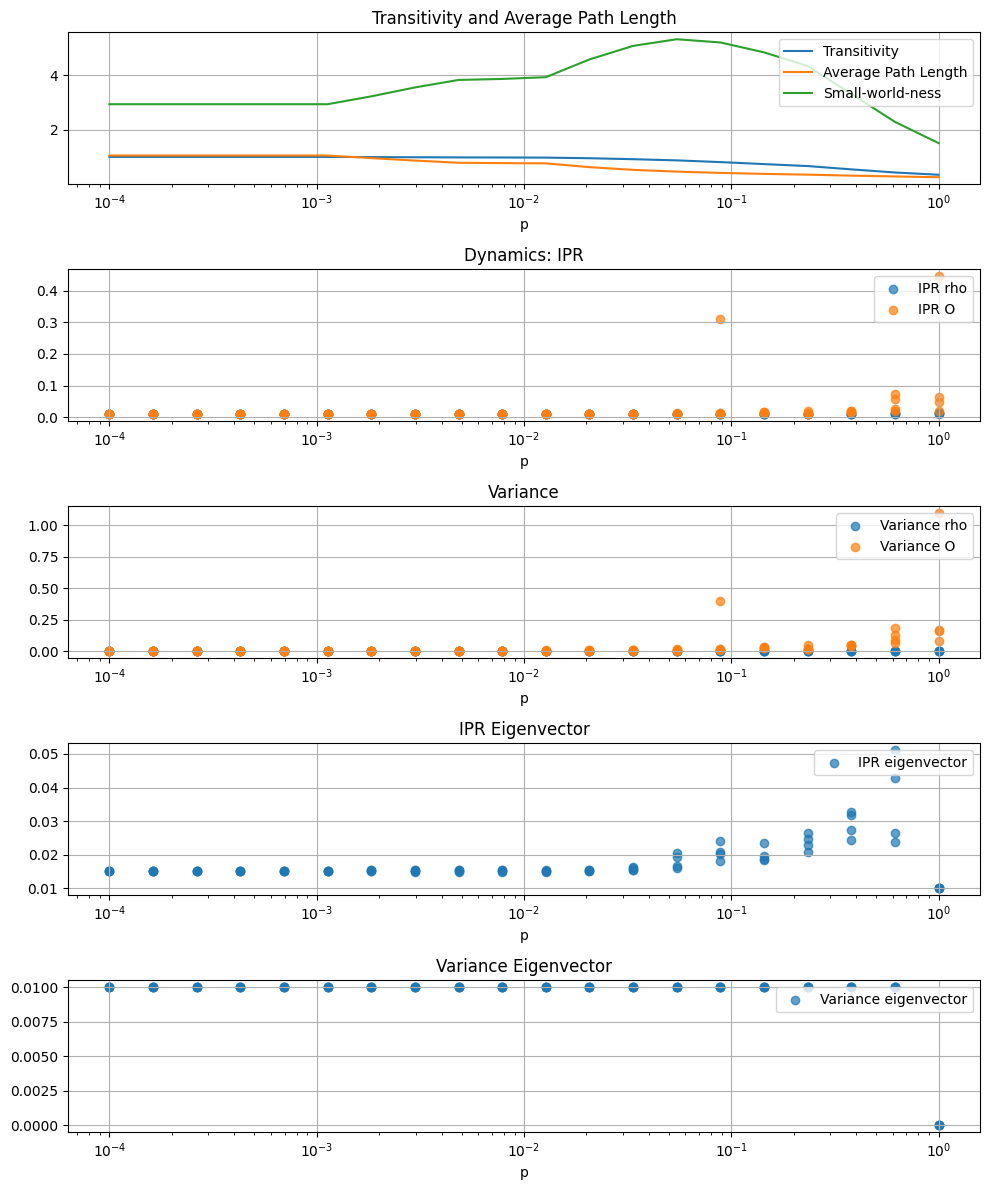

{'dynamics_data': {np.float64(0.0001): [{'critical_eigenvalue': -1.8309511902505324, 'last_values_rho': [0.008069771854413389, 0.007757668583907814, 0.00779308954682022, 0.00784841545751245, 0.0078093979452741775, 0.007910480467420773, 0.00802123094968836, 0.008095336433842557, 0.008191321269367217, 0.008217310624804002, 0.008190019393962491, 0.00808780538653605, 0.007922554686380378, 0.007845348039554697, 0.007638930845258545, 0.007450620907766475, 0.006810283346395814, 0.00564109949106046, 0.00735413778112388, 0.007932149226425815, 0.007939233581445574, 0.007939498521578938, 0.007934611155469694, 0.00794308971438014, 0.00794023174566722, 0.007937414263098103, 0.007936664916663654, 0.00794283554601118, 0.007938273710384027, 0.007939948111164061, 0.00794367616805837, 0.007939211980045886, 0.007941204048860957, 0.007938141309158129, 0.007938004218556486, 0.007933677256364291, 0.007932520090595753, 0.007939308701863238, 0.007942547349264268, 0.007942446214167924, 0.007939782048652443, 0.

In [13]:
experiment_5 = experiments(100, 6, 20, 4, params)
print(experiment_5)

In [ ]:
experiment_6 = experiments(200, 6, 20, 4, params)
print(experiment_6)

Starting the experiments...
Computing graph 1/20...
Starting the integration...Starting the integration...

Starting the integration...
Starting the integration...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Computations finished.
Computations finished.
Integration finished.Computations finished.
Linear algebra computations...

Computations finished.
Starting the integration...Starting the integration...Starting the integration...Starting the integration...



Computing graph 2/20...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Computations finished.
Computations finished.
Integration finished.Computations finished.
Linear algebra computations...

Computations finished.
Starting the integration...Starting the integration...

Starting the integration...
Starting

Process ForkPoolWorker-71:
Process ForkPoolWorker-72:
Process ForkPoolWorker-70:
Process ForkPoolWorker-69:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkPoolWorker-68:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-66:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkPoolWorker-65:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkPoolWorker-67:
  File "/usr/lib/pyt

In [ ]:
experiment_7 = experiments(600, 6, 20, 4, params)
print(experiment_7)

Starting the experiments...
Computing graph 1/20...
Starting the integration...
Starting the integration...
Starting the integration...
Starting the integration...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Computations finished.
Computations finished.
Computations finished.
Computations finished.
Computing graph 2/20...
Starting the integration...
Starting the integration...
Starting the integration...
Starting the integration...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Integration finished.
Linear algebra computations...
Computations finished.
Computations finished.
Computations finished.
Computations finished.
Computing graph 3/20...
Starting the integration...Starting the integration...Starting the i

/tmp/ipykernel_336285/1462665996.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  'critical_eigenvalue': float(eigenvalues[index_lambda_c]),


Computations finished.

/tmp/ipykernel_336285/1462665996.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  'ipr_eigenvector': float(ipr_eigenvector),



Computing graph 6/20...
Starting the integration...
Starting the integration...
Starting the integration...
Starting the integration...


Process ForkPoolWorker-77:
Process ForkPoolWorker-82:
Process ForkPoolWorker-83:
Process ForkPoolWorker-80:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-74:
Process ForkPoolWorker-76:
Traceback (most recent call last):
Process ForkPoolWorker-75:
Process ForkPoolWorker-73:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process